In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# SoH Prediction

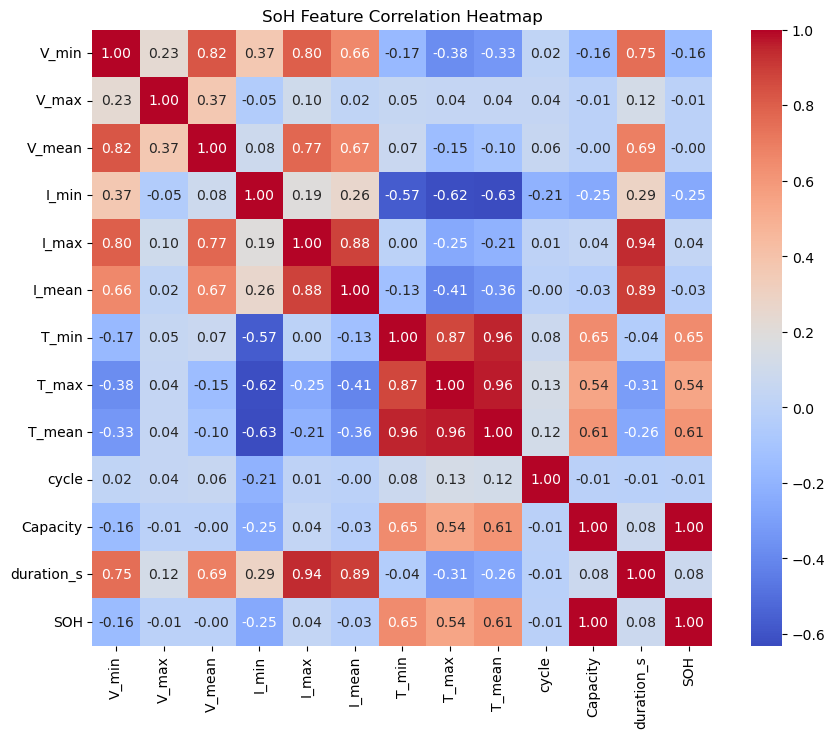

In [4]:
df = pd.read_csv('df_clean.csv')

soh_cols = ['V_min','V_max','V_mean', 'I_min','I_max', 'I_mean', 'T_min','T_max', 'T_mean', 'cycle', 'Capacity', 'duration_s','SOH']
df_numerical = df[soh_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('SoH Feature Correlation Heatmap')
plt.show()

In [89]:
#prepare features and target
feature_cols = [ 'T_min', 'T_mean', 'I_min', 'V_min','cycle', 'Capacity']
target_col = 'SOH'

x = df[feature_cols].values 
y = df[target_col].values.reshape(-1, 1)  # make 2D for scaler

# Scale inputs and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(x) #fit_transform = learn scaling + apply scaling
y_scaled = scaler_y.fit_transform(y)

In [91]:
#Create sequences for LSTM
SEQ_LENGTH = 100 # use last 100 cycles to predict next SOH

def create_sequences(x, y, seq_length):
    x_seq, y_seq = [], [] #making standard sliding window For every index i 100 rows of X → input sequence and 101th value of y → target is taken
    for i in range(len(x) - seq_length):
        x_seq.append(x[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(x_seq), np.array(y_seq)

x_seq, y_seq = create_sequences(x_scaled, y_scaled, SEQ_LENGTH)

#Define R2 metric for Keras (evaluation metrics)
def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) #squared error
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) #variance of true values
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon()) #as R² = 1 - (error / total variance)


In [93]:
x_train, x_test, y_train, y_test = train_test_split(
    x_seq, y_seq, test_size=0.2, shuffle=False  # No shuffle for time series
)


#LSTM model architecture
model = Sequential([
    Input(shape=(SEQ_LENGTH, len(feature_cols))), #expects sequences of shape (100, 6 features)
    LSTM(64, activation='tanh'), #main LSTM layer with recurrent dropout 
    Dropout(0.2),          # reduces overfitting
    Dense(16, activation='relu'),
    Dense(1, activation='linear') # Regression output
])

model.compile(optimizer='adam', loss='mae', metrics=[r2_keras]) # Using MAE and R2 for evaluation
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [20]:
# Train model
history = model.fit(
    x_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Predict on test set
y_pred_scaled = model.predict(x_test)


# Inverse scale predictions (to convert scaled values back to original SOH units)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)


Epoch 1/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1107 - r2_keras: -0.4164 - val_loss: 0.0550 - val_r2_keras: -25.3916
Epoch 2/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0499 - r2_keras: 0.7111 - val_loss: 0.0538 - val_r2_keras: -10.0642
Epoch 3/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0415 - r2_keras: 0.7721 - val_loss: 0.0407 - val_r2_keras: -15.8601
Epoch 4/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0376 - r2_keras: 0.7617 - val_loss: 0.0519 - val_r2_keras: -35.2985
Epoch 5/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0340 - r2_keras: 0.8147 - val_loss: 0.0364 - val_r2_keras: -5.1023
Epoch 6/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0325 - r2_keras: 0.8552 - val_loss: 0.0415 - val_r2_keras: -9.5272
Epoch 7/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0288 - r2_keras: 0.7462 - val_loss: 0.0458 - val_r2_keras: -18.1575
Epoch 8/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0281 - r2_ker

In [22]:
# Evaluate performance
# Testing results (MAE & R2)
test_mae = mean_absolute_error(y_true, y_pred)
test_r2 = r2_score(y_true, y_pred)

# Extract metrics from history
train_mae = history.history['loss']              # because loss = MAE
val_mae = history.history['val_loss']

train_r2 = history.history['r2_keras']
val_r2 = history.history['val_r2_keras']

# Final Training and Validation Results
final_train_mae = train_mae[-1]
final_val_mae = val_mae[-1]
final_train_r2 = train_r2[-1]
final_val_r2 = val_r2[-1]

print("\n SOH PREDICTION RESULTS")
print("\n TRAINING RESULTS")
print(f"Final Train MAE: {final_train_mae:.4f}")
print(f"Final Train R2:  {final_train_r2:.4f}")
print("\n VALIDATION RESULTS")
print(f"Final Val MAE:   {final_val_mae:.4f}")
print(f"Final Val R2:    {final_val_r2:.4f}")
print("\n TESTING RESULTS")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score:  {test_r2:.4f}")



 SOH PREDICTION RESULTS

 TRAINING RESULTS
Final Train MAE: 0.0104
Final Train R2:  0.9667

 VALIDATION RESULTS
Final Val MAE:   0.0170
Final Val R2:    -0.0205

 TESTING RESULTS
Test MAE: 3.1351
Test R2 Score:  0.6783


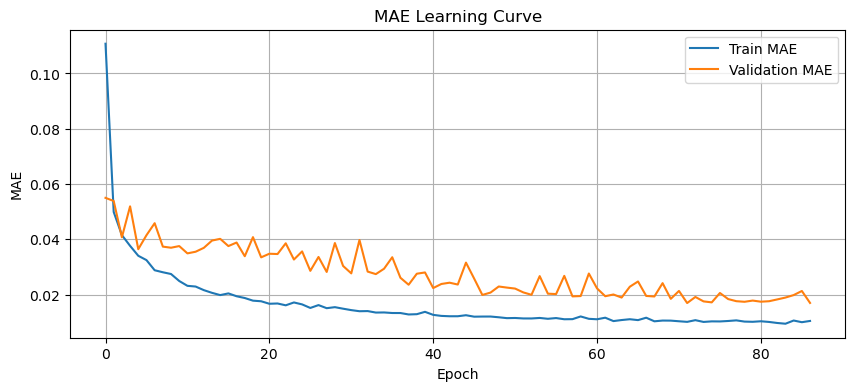

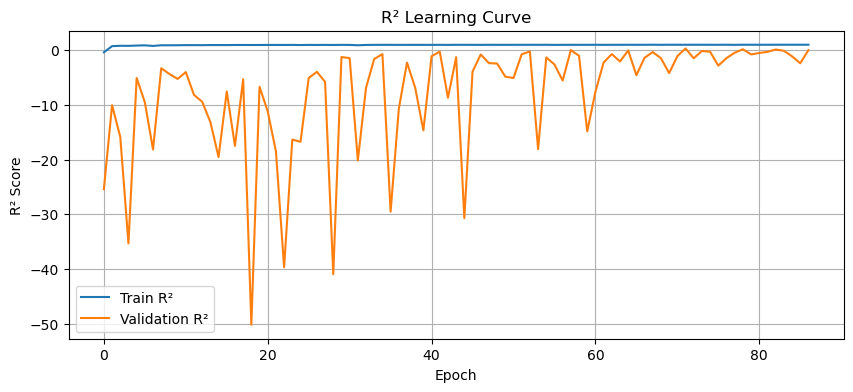

In [24]:
# Plot Learning Curves (MAE & R2)

# MAE plot 
plt.figure(figsize=(10,4))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

#  R2 plot 
plt.figure(figsize=(10,4))
plt.plot(train_r2, label='Train R²')
plt.plot(val_r2, label='Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Learning Curve')
plt.legend()
plt.grid(True)
plt.show()




In [26]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (4407, 100, 6)
y_train shape: (4407, 1)
x_test shape: (1102, 100, 6)
y_test shape: (1102, 1)


# Plots

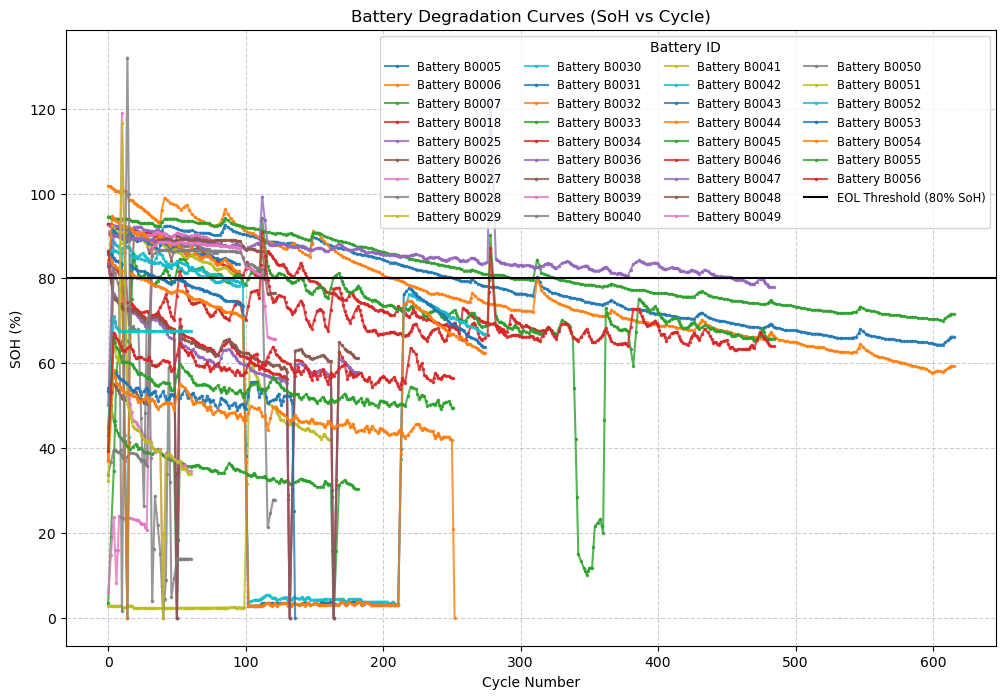

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# End-of-Life (EOL) threshold
EOL_THRESHOLD = 80  # SOH percent

# Setup plot
plt.figure(figsize=(12,8))

# Loop through each battery
for b in df['battery'].unique():
    bat_data = df[df['battery'] == b]
    plt.plot(
        bat_data['cycle'],
        bat_data['SOH'],
        label=f'Battery {b}',
        alpha=0.8,
        marker='.',
        markersize=3
    )

# Add EOL line
plt.axhline(
    y=EOL_THRESHOLD,
    color='k',
    linestyle='-',
    linewidth=1.5,
    label=f'EOL Threshold ({EOL_THRESHOLD}% SoH)'
)

# Titles and labels
plt.title('Battery Degradation Curves (SoH vs Cycle)')
plt.xlabel('Cycle Number')
plt.ylabel('SOH (%)')
plt.legend(title='Battery ID', loc='upper right', ncol=4, fontsize='small')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


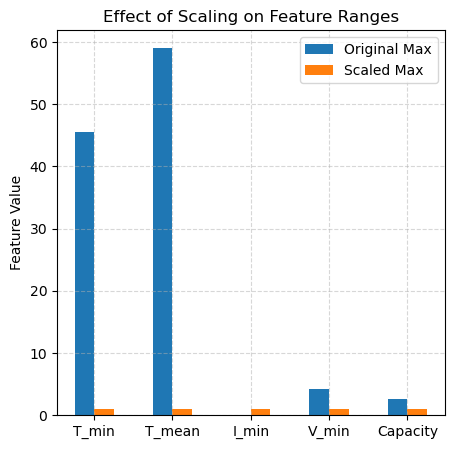

In [81]:
import numpy as np

min_vals = x.min() #the smallest value of that feature in dataset.
max_vals = x.max() #the largest value of that feature in dataset.
scaled_min = x_scaled.min() #the smallest value of the feature after scaling.
scaled_max = x_scaled.max() #the largest value of the feature after scaling.

x_pos = np.arange(len(feature_cols))
width = 0.25

plt.figure(figsize=(5,5))
plt.bar(x_pos - width/2, max_vals, width, label='Original Max')
plt.bar(x_pos + width/2, scaled_max, width, label='Scaled Max')
plt.xticks(x_pos, feature_cols)
plt.ylabel('Feature Value')
plt.title('Effect of Scaling on Feature Ranges')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
